In [1]:
import numpy as np
from keras.datasets import boston_housing
from keras.datasets import reuters
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
NUM_FOLD = 4

In [3]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

mean = train_data.mean(axis=0)
std = train_data.std(axis=0)

train_x = (train_data - mean) / std
train_y = train_targets.copy()

test_x = (test_data - mean) / std
test_y = test_targets.copy()

print("train_x.shape = {}, train_y.shape = {}".format(train_x.shape, train_y.shape))
print("test_x.shape = {}, test_y.shape = {}".format(test_x.shape, test_y.shape))

train_x.shape = (404, 13), train_y.shape = (404,)
test_x.shape = (102, 13), test_y.shape = (102,)


In [4]:
def build_model():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(13, )))
    model.add(Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [5]:
mae_history = []
num_val = len(train_x) // NUM_FOLD

for i in range(NUM_FOLD):
    print("processing fold {}".format(i))
    val_x = train_x[i * num_val:(i + 1) * num_val]
    val_y = train_y[i * num_val:(i + 1) * num_val]
    
    train_x_partial = np.concatenate([train_x[:i*num_val], train_x[(i + 1) * num_val:]], axis=0)
    train_y_partial = np.concatenate([train_y[:i*num_val], train_y[(i + 1) * num_val:]], axis=0)
    
    model = build_model()
    history = model.fit(train_x_partial, train_y_partial, epochs=50, batch_size=1,
                        validation_data=(val_x, val_y), verbose=0)
    mae_history.append(history.history['val_mean_absolute_error'])

processing fold 0
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
processing fold 1
processing fold 2
processing fold 3


In [6]:
ave_mae_history = np.mean(mae_history, axis=0)

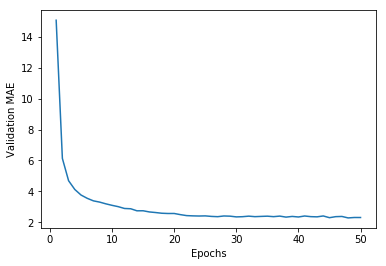

In [7]:
plt.figure()
epochs = range(1, len(ave_mae_history) + 1)
plt.plot(epochs, ave_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')

plt.show()

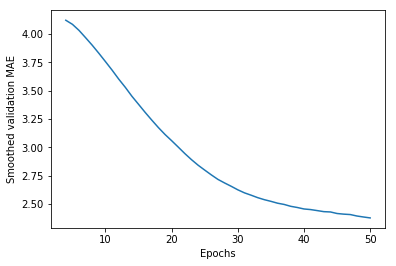

In [8]:
smoothed = []
factor = 0.9
num_exclude = 3
for value in ave_mae_history[num_exclude:]:
    if smoothed:
        prev = smoothed[-1]
        smoothed.append(prev * factor + value * (1 - factor))
    else:
        smoothed.append(value)

plt.figure()
epochs = range(num_exclude + 1, len(ave_mae_history) + 1)
plt.plot(epochs, smoothed)
plt.xlabel('Epochs')
plt.ylabel('Smoothed validation MAE')

plt.show()

In [9]:
model = build_model()
history = model.fit(train_x, train_y, epochs=30, batch_size=1, verbose=0)

test_mse, test_mae = model.evaluate(test_x, test_y)
print("test_mse = {}, test_mae = {}".format(test_mse, test_mae))

102/102 [==============================] - 0s 458us/step
test_mse = 19.906439986883424, test_mae = 2.7713561619029328
